# Face recognition using AdaBoost

## 1. Introduction

In this project we explored and implemented the AdaBoost algorithm to detect faces. AdaBoost is a boosting algorithm, that is based on the training of multiple weak classifiers that together form a much stronger classifier with higher predictive power. Here we will work with decision stumps as weak classifiers.  (Further information: [Decision stumps](https://en.wikipedia.org/wiki/Decision_stump))

The dataset we use contains grey-scale pictures of faces as well as pictures of non-faces (random pictures from the internet). In total there are around 4900 face images and around 7800 non-face images. All images are represented by a 24x24 matrix. 

The features used to train the weak classifiers for AdaBoost are Haar-Feature masks that are applied to the images. They mainly detect simple shapes like lines or edges by looking for differences in contrast, e.g. dark eyebrows vs. light forehead region. (Further information: [Haar-like features](https://medium.com/analytics-vidhya/what-is-haar-features-used-in-face-detection-a7e531c8332b))  <br> <br>

<!--- &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; for indented text--->

**Description of AdaBoost** <br> <br>
Given the data $\{(x_1, y_1), \dots, (x_n, y_n)\}$ with $ x_i \in \mathbb{R}^k, y_i \in Y = \{-1,1\}$ and $T = $ Number of weak classifiers to be trained, where $x_i$ is a column vector from the $[k \times n]$ feature matrix $X$ ($k$ = dimension of feature space, $n$ = number of examples) representing the feature values of sample $i$, repeat steps 2, 3 and 4 $\,T$-times:
  >1. Initialize weights $D_1 = \frac{1}{n} \;\;\; \forall x_i \in X$ for iteration $t=1$ <br><br>
  >2. Find optimal weak classifier $h_t(x)$ from the set of all possible decision stumps in all feature dimensions $k$, that minimizes the weighted error $\varepsilon_t = \sum_{i=1}^n d_t(x_i)I(y_i \neq h_t(x_i))$ for iteration $t$ <br><br>
  >3. Update weights $d_{t+1}(x_i)=d_t(x_i)\;e^{-\alpha_t y_t h_t(x_i)}$ where $\alpha_t = \frac{1}{2}\ln(\frac{1-\varepsilon_t}{\varepsilon_t})$ <br><br>
  >4. Renormalize weights $d_{t+1}(x_i) = \frac{d_{t+1}(x_i)}{\sum_{i=1}^nd_{t+1}(x_i)} \;\;$ s.t. $\;\sum_{i=1}^nd_{t+1}(x_i)=1$ <br><br>

The resulting strong classifier $H(x_i)$ predicts labels as the sign of the sum of the decision obtained by the $T$ different decision stumps, weighted by their respective $\alpha$-value which reflects the predictive power of weak classifier. The formal representation of $H(x_i)$ can be written as followes: <br> 
$$H(x_i) = sign\big(\sum_{t=1}^T \alpha_t h_t(x_i)\big)$$

<br>
    
</p>

## 2. Load the data and generate Haar-features

In the first step we load the face-images (\~4900) and non-face-images (\~7800) from the files and generate random Haar-features later used as features for AdaBoost-Training.



In [20]:
%reload_ext autoreload
%autoreload 2 # Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.

import numpy as np
from matplotlib import pyplot as plt
from scipy import io as sio

from utils import GenerateHaarFeatureMasks, ExtractHaarFeatures
from classifier import WeakClassifier, WeakClassifierError, AdaBoost, TrainWeakClassifier

plt.rcParams['figure.facecolor']='white'

### Load all images

In [27]:
# Hyper-parameters

# Number of randomized Haar-features
nbrHaarFeatures = 500

# Number of training images, will be evenly split between faces and non-faces. 
nbrTrainImages = 1500 

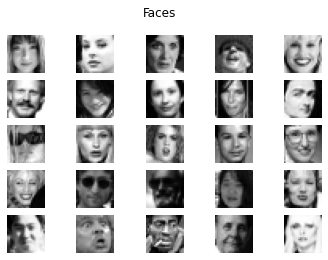

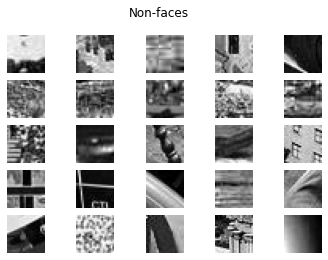

In [28]:
# Load face and non-face data and plot a few examples
faces = sio.loadmat('faces.mat')['faces']
nonfaces = sio.loadmat('nonfaces.mat')['nonfaces']

faces = faces.astype('double')[:,:,np.random.permutation(faces.shape[-1])]
nonfaces = nonfaces.astype('double')[:,:,np.random.permutation(nonfaces.shape[-1])]

plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(faces[:,:,10*i], cmap='gray')
    plt.axis('off')
plt.suptitle('Faces')

plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(nonfaces[:,:,10*i], cmap='gray')
    plt.axis('off')
plt.suptitle('Non-faces')
plt.show()

#plt.savefig("Pictures/Faces_non_faces", bbox_inches='tight')

### Generate Haar-features

The following code first generates nbrHaarFeatures different Haar-feature-masks that are then applied to all the images selected as Training and Test data. This results in the $[nbrHaarFeatures \times n]$ feature matrix $X$, where one row represents the result of one Haar-feature applied to all of the $n$ example images. 

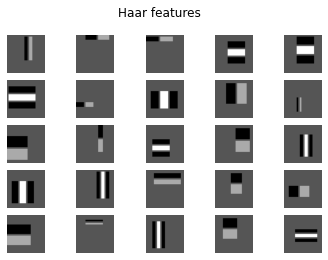

In [29]:
# Generate random Haar feature masks
haarFeatureMasks = GenerateHaarFeatureMasks(nbrHaarFeatures)

# 0 is grey, -1 is black, 2 is white -> nose bright, under eyes black, then there will be a high value, indicating yes
# Computation
plt.figure()
for k in range(25):
    plt.subplot(5,5,k+1)
    plt.imshow(haarFeatureMasks[:,:,k], cmap='gray', vmin=-1, vmax=2)
    plt.axis('off')
plt.suptitle('Haar features')
#plt.savefig("Pictures/All_haar_examp", bbox_inches='tight')
plt.show()

In [30]:
# Create image sets 

# Create a training data set with examples from both classes.
# Non-faces = class label y=-1, faces = class label y=1
trainImages = np.concatenate((faces[:,:,:nbrTrainImages//2], nonfaces[:,:,:nbrTrainImages//2]), axis=2)

xTrain = ExtractHaarFeatures(trainImages,haarFeatureMasks)
yTrain = np.concatenate((np.ones(nbrTrainImages//2), -np.ones(nbrTrainImages//2)))

# Create a test data set, using the rest of the faces and non-faces.
testImages  = np.concatenate((faces[:,:,nbrTrainImages//2:], nonfaces[:,:,nbrTrainImages//2:]), axis=2)

xTest = ExtractHaarFeatures(testImages,haarFeatureMasks)
yTest = np.concatenate((np.ones(faces.shape[2]-nbrTrainImages//2), -np.ones(nonfaces.shape[2]-nbrTrainImages//2)))

# Variable for the number of test-data.
nbrTestImages = yTest.shape

In [31]:
xTrain.shape # 500 different Haar-features x 1500 Training images

(500, 1500)

## 3. Training Example of AdaBoost

The following code shows an example of the application of the AdaBoost-algorithm using 20 decision stumps. 

In [32]:
X = xTrain
Y = yTrain

StrongClass, features, idx, alpha = AdaBoost(X, Y, 20, random_choice=False)

pred_train = StrongClass(features)
error_train = np.sum(pred_train==Y)/X.shape[1]

test_features = xTest[idx, ]
pred_test = StrongClass(test_features)
error_test = np.sum(pred_test==yTest)/xTest.shape[1]

AdaBoost Training Progress

[========================================] 100.0%

In [33]:
print(f"Training accuracy:  {error_train*100:.2f}%\n")
print(f"Test accuracy:      {error_test*100:.2f}%")

Training accuracy:  95.53%

Test accuracy:      92.90%


## 4. Decide on optimal number of classifiers

Even though we train AdaBoost on a certain number of weak classifiers, we do not need to use all of them for prediction. Instead we can only use a subset of them. Let $S$ be a subset of all trained decision stumps and $\hat{y}_i$ the predicted label of example $x_i$, then we can compute the prediction of AdaBoost just using these weak classifiers as follows: 
$$\hat{y}_i = sign\big(\sum_{t \in S} \alpha_t h_t(x_i)\big)$$

To get a good estimate of the accuracies and to be able to decide on the best number of weak classifiers to use for prediction, we train AdaBoost on 500 decision stumps and plot the Test and Training accuracy depending on the used number of weak classifiers. 

In [34]:
from time import time
now = time()

X = xTrain
Y = yTrain

# Train strong classifier
StrongClass, features, idx, alpha = AdaBoost(X, Y, 500, random_choice=False)

print(f"\n\nTraining time: {time()-now:.2f} sec")

AdaBoost Training Progress

[========================================] 100.0%

Training time: 4775.20 sec


In [35]:
# compute all accuracies for different number of weak classifiers

accuracy_dict = {"n_class": list(),
                 "train_errors": list(),
                "test_errors": list()}

for num_class in np.arange(1,500):
    pred_train = StrongClass(features, n_class=num_class)
    error_train = np.sum(pred_train==Y)/X.shape[1]

    test_features = xTest[idx, ]
    pred_test = StrongClass(test_features, n_class=num_class)
    error_test = np.sum(pred_test==yTest)/xTest.shape[1]

    accuracy_dict["n_class"].append(num_class)
    accuracy_dict["train_errors"].append(error_train)
    accuracy_dict["test_errors"].append(error_test)

In [37]:
# get the number of weak classifiers with the maximum test accuracy

class_number = accuracy_dict["n_class"]
train_errors = accuracy_dict["train_errors"]
test_errors = accuracy_dict["test_errors"]

opt_idx = np.argmax(test_errors)
n_class_opt = class_number[opt_idx]
max_test_acc = test_errors[opt_idx]
max_train_acc = train_errors[opt_idx]

print(f"N-class with max. test-accuracy: {n_class_opt}, Accuracy: {max_test_acc:.4f}")

N-class with max. test-accuracy: 439, Accuracy: 0.9639


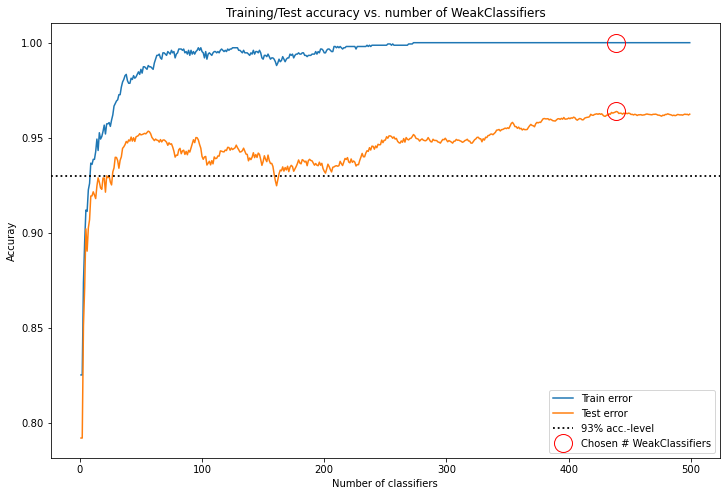

In [38]:
plt.figure(figsize=(12, 8))

plt.plot(class_number, train_errors, label="Train error") 
plt.plot(class_number, test_errors, label="Test error") 
plt.xlabel("Number of classifiers")
plt.ylabel("Accuray")
plt.title(f"Training/Test accuracy vs. number of WeakClassifiers")
plt.axhline(0.93, color = "black", linestyle=":", linewidth=1.8, label="93% acc.-level")

plt.plot(n_class_opt, max_train_acc, 'o', fillstyle='none', markersize=18, color="red", label="Chosen # WeakClassifiers")
plt.plot(n_class_opt, max_test_acc,'o', fillstyle='none', markersize=18, color="red")

plt.legend(loc="lower right")

#plt.savefig("Pictures/n_Haarvsaccuracy", bbox_inches='tight')

## 5. Get Accuracy of final StrongClassifier

The chosen classifier uses 439 WeakCLassifiers to get the final prediction. 

In [39]:
from functools import partial

num_class = n_class_opt

FinalStrongClass = partial(StrongClass, n_class=num_class)

pred_train = FinalStrongClass(features)
error_train = np.sum(pred_train==Y)/X.shape[1]

test_features = xTest[idx, ]
pred_test = FinalStrongClass(test_features)
error_test = np.sum(pred_test==yTest)/xTest.shape[1]

print(f"Training accuracy:   {error_train:.4f}")
print(f"Testing accuracy:    {error_test:.4f}")

Training accuracy:   1.0000
Testing accuracy:    0.9639


## 6. Comparison to random choice of features

In the following we compare the results obtained above with a slight modification of AdaBoost: Instead of choosing the WeakClassifier leading to the lowest weighted error for the respective iteration, we choose one of the Haar-features at random, which is decreasing the computational complexity immensly. 

In the standard case, we train $W\cdot F \cdot N$ decision stumps ($W$=Number of WeakClassifiers, $F$=Number of possible features, $N$=Number of data points) since in every iteration $W$ there are $F$ possible choices for decision stumps where $N$ thresholds need to be compared for every of those possible weak classifiers. Choosing a feature at random on the other hand leads to the training of $W \cdot N$ decision stumps. So the complexity is reduced from $O(W\cdot F \cdot N)$ to $O(W \cdot N)$ instead.

In [40]:
now = time()

# Train strong classifier with random feature selection
StrongClassRndm, features, idx, alpha = AdaBoost(X, Y, 500, random_choice=True)

print(f"Training time: {time()-now:.2f} sec")

Training time: 9.36 sec


In [41]:
diff = 4775/9.36

print(f"The random feature selection was ~{diff-1:.0f}x faster.")

The random feature selection was ~509x faster.


In [43]:
accuracy_dict = {"n_class":list(),
                 "train_errors":list(),
                "test_errors":list()}

for num_class in np.arange(1,500):
    pred_train = StrongClassRndm(features, n_class=num_class)
    error_train = np.sum(pred_train==Y)/X.shape[1]

    test_features = xTest[idx, ]
    pred_test = StrongClassRndm(test_features, n_class=num_class)
    error_test = np.sum(pred_test==yTest)/xTest.shape[1]

    accuracy_dict["n_class"].append(num_class)
    accuracy_dict["train_errors"].append(error_train)
    accuracy_dict["test_errors"].append(error_test)

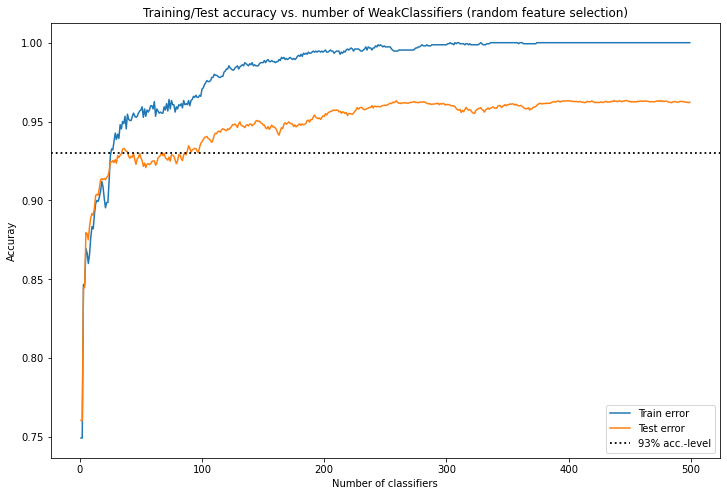

In [44]:
plt.figure(figsize=(12, 8))
class_number = accuracy_dict["n_class"]
train_errors = accuracy_dict["train_errors"]
test_errors = accuracy_dict["test_errors"]


plt.plot(class_number, train_errors, label="Train error") 
plt.plot(class_number, test_errors, label="Test error") 
plt.xlabel("Number of classifiers")
plt.ylabel("Accuray")
plt.title(f"Training/Test accuracy vs. number of WeakClassifiers (random feature selection)")
plt.axhline(0.93, color = "black", linestyle=":", linewidth=1.8, label="93% acc.-level")

plt.legend(loc="lower right")

#plt.savefig("Pictures/random_choice", bbox_inches='tight')

In [46]:
print(f"Best test accuracy for random feature selection: {max(test_errors)*100:.2f}%")

Best test accuracy for random feature selection: 96.34%


We can see that Training is much faster (**509x speedup!**) but in general we need more weak classifiers to reach the 93% accuracy threshold and the maximal reached accuracy is 96.34% in comparison to 96.39% for the optimal case (other trials sometimes showed a bigger gap in accuracies). But stil, with an increasing number of WeakClassifiers used for prediciton, Training and Test accuracy increase and the results are almost comparable to the optimal feature selection while being a lott less computationally complex.

## 7. Plots of the results

**Prediciton examples**

The following plot shows some of the pictures that were correctly classified as faces (first row) and some misclassifications (second and third row). RL in this context means real label (1 = face, -1 = non-face) and PL means predicted label. 

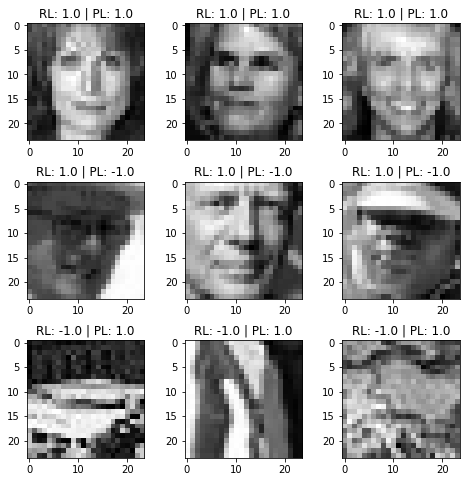

In [47]:
# Plot some of the misclassified faces and non-faces
# Use the subplot command to make nice figures with multiple images.
permutate = np.random.randint(0, 50)

misclass_idx = np.where(pred_test != yTest)[0]
first_three = misclass_idx[0+permutate:3+permutate]
last_three = misclass_idx[-3-permutate:-permutate]
right_three = np.where(pred_test == yTest)[0][:3]

print_idx = np.concatenate((right_three, first_three, last_three))
images = testImages[:,:,print_idx]
pred_labels = pred_test[print_idx, ]
real_labels = yTest[print_idx]

plt.figure(figsize=(8,8))
for i in range(len(pred_labels)):
    plt.subplot(3,3, i+1)
    plt.imshow(testImages[:, :, print_idx[i]], cmap='gray')
    plt.title(f"RL: {real_labels[i]} | PL: {pred_labels[i]}")
    
plt.subplots_adjust(hspace=0.35)
#plt.savefig("Pictures/predictions", bbox_inches='tight')

**Most important Haar-features**

The next plot shows the 25 most important chosen Haar-features according to their $\alpha$-value.

In [48]:
alpha = np.array(alpha)
importance_index = np.array(list(reversed(np.argsort(alpha))))  # get indexes of highest alphas
idx = np.array(idx)
chosen = idx[importance_index[:25]]  # 25 most important features

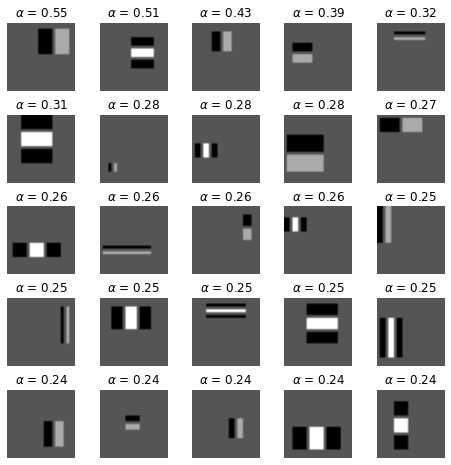

In [49]:
# Plot your choosen Haar-features
# Use the subplot command to make nice figures with multiple images.

plt.figure(figsize=(8,8))
for k in range(25):
    next_idx = chosen[k]
    plt.subplot(5,5,k+1)
    plt.imshow(haarFeatureMasks[:,:,next_idx], cmap='gray', vmin=-1, vmax=2)
    plt.axis('off')
    plt.title(r"$\alpha$ = " + f"{alpha[importance_index[k]]:.2}")
    
plt.subplots_adjust(hspace=0.35)
#plt.suptitle('Haar features')
#plt.savefig("Pictures/Haar", bbox_inches='tight')
plt.show()

**Chosen Haar-features plotted on faces**

The following illustration shows the 5 most important Haar-features applied to 5 random faces. 

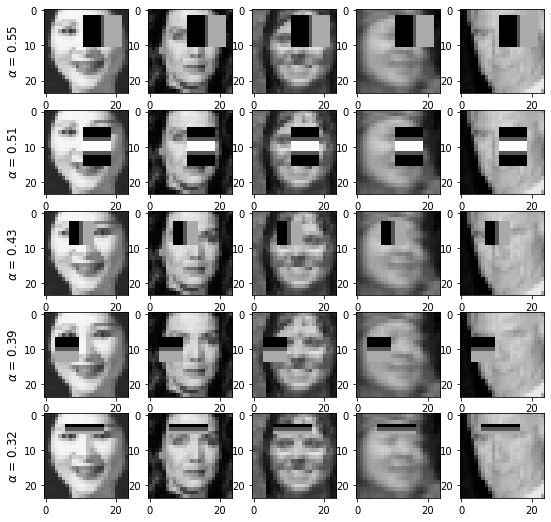

In [50]:
# plot 5 most important Haar features on pictures

plt.figure(figsize=(9,9))

for i in range(5):
    
    for n in range(5):
        plt.subplot(5,5, i+1+5*(n))
        haar = haarFeatureMasks[:,:,chosen[n]]
        img = np.copy(testImages[:,:,np.where(pred_test == yTest)[0][45+i]])
        img = (img/255)*3 - 1

        filter_idx = np.where(haarFeatureMasks[:,:,chosen[n]] != 0)
        row, col = (min(filter_idx[0]), max(filter_idx[0])), (min(filter_idx[1]), max(filter_idx[1]))
        img[row[0]:row[1]+1, col[0]:col[1]+1] = haar[row[0]:row[1]+1, col[0]:col[1]+1]

        plt.imshow(img, cmap='gray', vmin=-1, vmax=2)
        
        if i%6==0:
            ax = plt.gca()
            ax.set_ylabel(str(r"$\alpha$ = " + f"{alpha[importance_index[n]]:.2}"), rotation=90, size='large')

    #plt.title(f"RL: {real_labels[i]} | PL: {pred_labels[i]}")
plt.savefig("Pictures/haar_on_face", bbox_inches='tight')